<a href="https://colab.research.google.com/github/Joe270585/Treinamento_e_Detec-o_com_Rede_Yolo/blob/main/Deteccao_com_Rede_Yolov5.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# Instalações, importações e configurações

#Clonando o repositório da YOLOv5 do github e entrando no diretório
!git clone https://github.com/ultralytics/yolov5.git
%cd yolov5

#Instalando as dependências
!pip install -r requirements.txt

#Bibliotecas que foram utilizadas
import torch
import os
import json
import requests
import cv2
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
from google.colab import files
from pycocotools.coco import COCO # Import the COCO class
uploaded = files.upload()

#Desabilitando o W&B
os.environ["WANDB_MODE"] = "dryrun"

#Baixando o arquivo de anotações do COCO
!wget http://images.cocodataset.org/annotations/annotations_trainval2017.zip
!unzip -q annotations_trainval2017.zip


Cloning into 'yolov5'...
remote: Enumerating objects: 17581, done.
remote: Counting objects: 100% (65/65), done.
remote: Compressing objects: 100% (56/56), done.
remote: Total 17581 (delta 41), reused 9 (delta 9), pack-reused 17516 (from 4)
Receiving objects: 100% (17581/17581), 16.64 MiB | 16.51 MiB/s, done.
Resolving deltas: 100% (12037/12037), done.
/content/yolov5
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 15.1 MB/s eta 0:00:00


Saving baixados (1).webp to baixados (1).webp
--2025-09-18 01:06:58--  http://images.cocodataset.org/annotations/annotations_trainval2017.zip
Resolving images.cocodataset.org (images.cocodataset.org)... 54.231.169.241, 52.217.125.33, 52.217.103.164, ...
Connecting to images.cocodataset.org (images.cocodataset.org)|54.231.169.241|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 252907541 (241M) [application/zip]
Saving to: ‘annotations_trainval2017.zip’

annotations_trainva 100%[===================>] 241.19M  70.2MB/s    in 3.8s    

2025-09-18 01:07:02 (63.5 MB/s) - ‘annotations_trainval2017.zip’ saved [252907541/252907541]



In [ ]:
import torch
import os
import json
import requests
#Change directory to yolov5
%cd /content/yolov5

#Definindo o caminho do JSON
COCO_file = "annotations/instances_train2017.json"
coco = COCO(COCO_file)

#Modelo pre-treinado da YOLOv5
!wget -O yolov5s.pt https://github.com/ultralytics/yolov5/releases/download/v7.0/yolov5s.pt

#Carregando o modelo YOLOv5 pré-treinado
model = torch.hub.load('ultralytics/yolov5', 'yolov5s')

#Definindo as classes desejadas
classes_escolhidas = ["plant", "food-other"]

#Obtendo os IDs das classes no COCO
categoria_ids = coco.getCatIds(catNms=classes_escolhidas)

#Obtendo IDs das imagens que contêm essas classes
image_ids = []
for cat_id in categoria_ids:
    image_ids.extend(coco.getImgIds(catIds=cat_id))
image_ids = list(set(image_ids))

#Criando  o diretório para salvar as imagens
image_dir = "coco_custom_dataset/images"
os.makedirs(image_dir, exist_ok=True)

#Baixando as imagens associadas
for img_id in image_ids[:100]:  # Pegando apenas 100 imagens
    img_info = coco.loadImgs(img_id)[0]
    img_url = img_info['coco_url']
    img_name = os.path.join(image_dir, f"{img_id}.jpg")

    response = requests.get(img_url, stream=True)
    if response.status_code == 200:
        with open(img_name, 'wb') as f:
            for chunk in response.iter_content(1024):
                f.write(chunk)

#Criando diretório para salvar as anotações
label_dir = "coco_custom_dataset/labels"
os.makedirs(label_dir, exist_ok=True)

#Carregando os dados do COCO
with open(COCO_file, 'r') as f:
    coco_data = json.load(f)

#Criando um mapeamento de classes
class_map = {coco_data["categories"][i]["name"]: i for i in range(len(coco_data["categories"]))}

#Criando arquivos de anotações para cada imagem
for img_id in image_ids[:100]:
    img_info = coco.loadImgs(img_id)[0]
    ann_ids = coco.getAnnIds(imgIds=img_id, catIds=categoria_ids, iscrowd=False)
    anns = coco.loadAnns(ann_ids)

    #Criando arquivo .txt para cada imagem
    label_file = os.path.join(label_dir, img_info['file_name'].replace('.jpg', '.txt'))
    with open(label_file, 'w') as f:
        for ann in anns:
            bbox = ann["bbox"]
            x_center = (bbox[0] + bbox[2] / 2) / img_info['width']
            y_center = (bbox[1] + bbox[3] / 2) / img_info['height']
            width = bbox[2] / img_info['width']
            height = bbox[3] / img_info["height"]

            # Obtendo o ID da classe no COCO
            class_name = [k for k, v in class_map.items() if v == ann["category_id"]][0]
            class_id = classes_escolhidas.index(class_name)

            f.write(f"{class_id} {x_center} {y_center} {width} {height}\n")

#Criando o arquivo de configuração dataset.yaml
dataset_yaml = """\
train: coco_custom_dataset/images
val: coco_custom_dataset/images
nc: 2
names: ['plant', 'food-other']
"""
with open("dataset.yaml", "w") as f:
    f.write(dataset_yaml)

/content/yolov5
loading annotations into memory...
Done (t=30.19s)
creating index...
index created!
--2025-09-18 01:07:52--  https://github.com/ultralytics/yolov5/releases/download/v7.0/yolov5s.pt
Resolving github.com (github.com)... 140.82.114.4
Connecting to github.com (github.com)|140.82.114.4|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://release-assets.githubusercontent.com/github-production-release-asset/264818686/381bd8a8-8910-4e9e-b0dd-2752951ef78c?sp=r&sv=2018-11-09&sr=b&spr=https&se=2025-09-18T01%3A56%3A01Z&rscd=attachment%3B+filename%3Dyolov5s.pt&rsct=application%2Foctet-stream&skoid=96c2d410-5711-43a1-aedd-ab1947aa7ab0&sktid=398a6654-997b-47e9-b12b-9515b896b4de&skt=2025-09-18T00%3A55%3A48Z&ske=2025-09-18T01%3A56%3A01Z&sks=b&skv=2018-11-09&sig=gxEmE7hn5SA%2BlR323%2BrLxkwUNyG835sVZH3%2BlJfzZYU%3D&jwt=eyJ0eXAiOiJKV1QiLCJhbGciOiJIUzI1NiJ9.eyJpc3MiOiJnaXRodWIuY29tIiwiYXVkIjoicmVsZWFzZS1hc3NldHMuZ2l0aHVidXNlcmNvbnRlbnQuY29tIiwia2V5Ijoia2V5M

/usr/local/lib/python3.12/dist-packages/torch/hub.py:330: UserWarning: You are about to download and run code from an untrusted repository. In a future release, this won't be allowed. To add the repository to your trusted list, change the command to {calling_fn}(..., trust_repo=False) and a command prompt will appear asking for an explicit confirmation of trust, or load(..., trust_repo=True), which will assume that the prompt is to be answered with 'yes'. You can also use load(..., trust_repo='check') which will only prompt for confirmation if the repo is not already trusted. This will eventually be the default behaviour
  warnings.warn(


Downloading: "https://github.com/ultralytics/yolov5/zipball/master" to /root/.cache/torch/hub/master.zip
Creating new Ultralytics Settings v0.0.6 file ✅ 
View Ultralytics Settings with 'yolo settings' or at '/root/.config/Ultralytics/settings.json'
Update Settings with 'yolo settings key=value', i.e. 'yolo settings runs_dir=path/to/dir'. For help see https://docs.ultralytics.com/quickstart/#ultralytics-settings.


YOLOv5 🚀 2025-9-18 Python-3.12.11 torch-2.8.0+cu126 CPU

Fusing layers... 
YOLOv5s summary: 213 layers, 7225885 parameters, 0 gradients, 16.4 GFLOPs
Adding AutoShape... 


In [ ]:
from pycocotools.coco import COCO

I've moved the import of the `COCO` class to a separate cell. Please run it before executing the cell that uses the `COCO` class.

In [ ]:
#Treinando o modelo sem W&B e sem logs indesejados
!python train.py --img 640 --batch 16 --epochs 100 --data dataset.yaml --weights yolov5s.pt

#Testando o modelo treinado
!python detect.py --weights runs/train/exp/weights/best.pt --source caminho/para/imagem.jpg


wandb: WARNING ⚠️ wandb is deprecated and will be removed in a future release. See supported integrations at https://github.com/ultralytics/yolov5#integrations.
2025-09-18 01:08:46.099133: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:467] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1758157726.501426    5521 cuda_dnn.cc:8579] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1758157726.606050    5521 cuda_blas.cc:1407] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
W0000 00:00:1758157727.271212    5521 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking the same target more than once.
W0000 00:00:1758157727.271263    5521 computation_placer.cc:177] computation placer already registere

Saving 22.jpg to 22.jpg


/root/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:906: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):


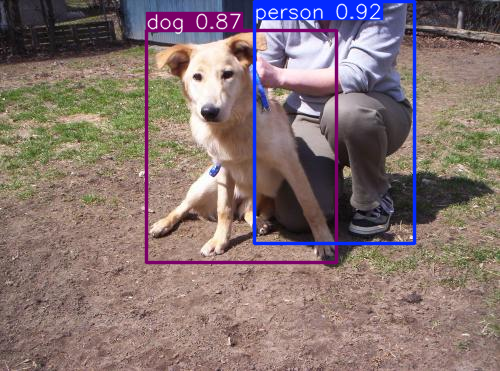

Saved 1 image to .11


In [ ]:
from google.colab import files
import cv2
import matplotlib.pyplot as plt
from PIL import Image
import numpy as np

uploaded = files.upload()

#Nome do arquivo ultilizado
image_path = list(uploaded.keys())[0]

#Carregar e processar imagem
img = Image.open(image_path)

#Fazendo a detecção
results = model(img)
results.show()

#Salvando a imagem com as border boxing
results.save(save_dir='./')

#Exibe a imagem no colab
img_resultado = cv2.imread(f'./{image_path}')
img_resultado = cv2.cvtColor(img_resultado, cv2.COLOR_BGR2RGB)

plt.figure(figsize=(10, 5))
plt.imshow(img_resultado)
plt.axis('off')
plt.show()